# Makemore Part 2

In [1]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# is this a good model?
# loss may get close to zero by increasing model size
# if you try to evaluate on withheld names, loss can be high
# so standard in the field is to split dataset into three splits
# training, validation, test 
# 80%, 10%, 10%

# 80% used to optimize model params
# 10% used for hyperparams optimization 
# see which ones work best for validation split
# 10% used for evaluating model at end
# every tiem you evaluate your test loss, you're starting to train on test split
# so only allowed to test on test split very few times, otherwise you risk overfitting to it
block_size = 3

# context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y=[],[] # x input to NN, Y labels
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)     
            Y.append(ix)
            # print(context, ix)
            # this context takes the second character til the end 
            # so always trims off the first character
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [39]:
# RESET part 2 with training data set
Xtr # input data
Ytr # labels
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
hidden_layer_size = 200
embed_dims = 10
C = torch.randn((vocab_size,embed_dims), generator=g)
W1 = torch.randn((block_size * embed_dims, hidden_layer_size), generator=g)
b1 = torch.randn((hidden_layer_size,))
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

11897


In [40]:
# set up neural network
# single batch
# loss doesn't go to zero, but ... predicts multiple values
# so loss can never go to zero
# this is also only a single batch, so 3481 parmaeters
# easy to fit to this batch.

# we want to randomly select a mini batch and forward and update on minibatch
# better to have approximate gradient and take many steps
# than exact gradient with fewer steps
stepi = []
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward
    emb = C[Xtr[ix]] 
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, learning rate increases over time
    # keep track of learning rates we use and look at 
    # losses that resulted
    if i > 200000:
        lr = 0.01
    elif i > 100000:
        lr = 0.05 # 1e-1 # lrs[i] # decay learning rate 
    else:
        lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.287246


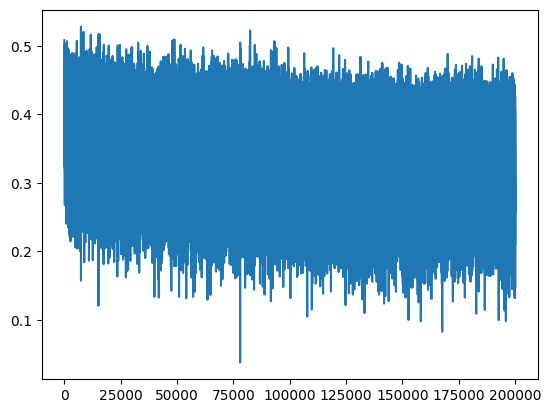

In [29]:
plt.plot(stepi, lossi)

In [30]:
# evaluate loss for TRAINING SEt
@torch.no_grad()
def print_loss():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1,block_size * embed_dims) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print("training_loss", loss.item())

    # training and dev loss are about equal
    # this means we can scale up the size we are underfitting.

    # easiest way to do this is to scale up hidden layers
    # evaluate loss for DEV SET
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1,block_size * embed_dims) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print("validation_loss", loss.item())
print_loss()

training_loss 2.1070516109466553
validation_loss 2.1754932403564453


In [31]:
# Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (3,block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahzabelle.
khyrilli.
tetylena.
sand.
mahutca.
pesynci.
geni.
jermara.
chriha.
kaleigh.
ham.
jose.
quint.
sulie.
alianni.
waleen.
dearini.
jaxen.
ivrat.
emmedi.


In [23]:
# PROBLEM 1
# first, we can figure out that initialization is bad
# because loss is around 27 to start. but we don't believe any character
# is more likely than any other. this rapidly comes down to 1 or 2

# in training of NN, it's almost always the case you will have an idea of 
# what loss to expect at initialization

# we can calculate this
# at init: 27 chars to come next for any training example
# at init, no reason to believe anything is more likely than others
# uniform distribution 
# prob for any char is ~ 1/27.0

-torch.tensor(1/27.0).log()

# so what is happening is that NN is creating prob dist that are very bad
# then network is confidently wrong. this is what makes it very high loss

# with more extreme values, you are more likely to be guessing the wrong value confidently
# we want logits to be roughly zero when 
# or roughly equal to start

# so how can we achieve logits that come out better?
# don't add bias of random numbers

# b2 = 0
# h @ W2 - if we want logits small, scale down W2 by 
# h @ W2 * .1

# why don't you want to set W2 to 0?
# because you want some entropy
# now loss doesn't look like hockey stick
# loss is quite a bit improved. now to 2.15
# training_loss 2.1070516109466553
# validation_loss 2.1754932403564453

tensor(3.2958)

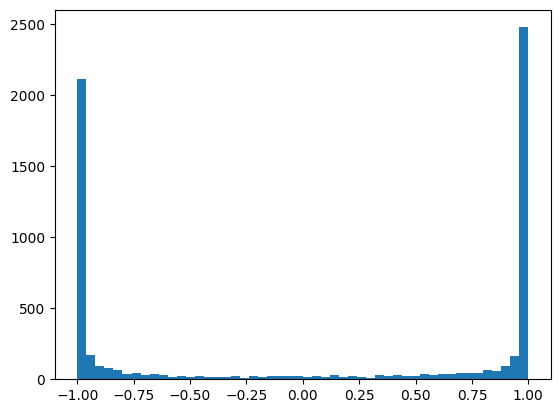

In [41]:
# PROBLEM 2
# a deeper problem in initialization
# logits are OK
# problem is with values of h
# activations of hidden states
# roughly speaking, many values of h are 1 or -1
# tanh is a squashing function. takes arbitrary numbers
# into range of -1 to 1

h1.shape
plt.hist(h1.view(-1).tolist(),50);

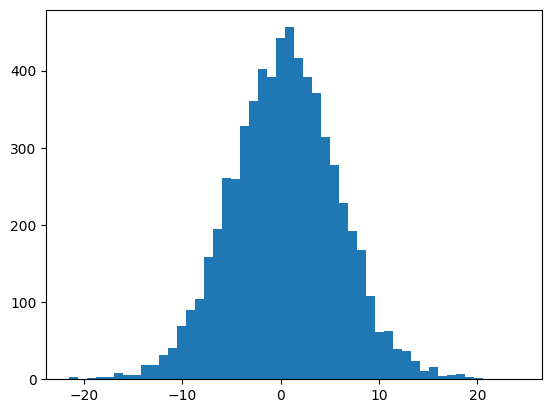

In [42]:
# this tanh is very very active. 
# we look at preactivations 
plt.hist(hpreact.view(-1).tolist(),50);

# we see distribution of preactivations take numbers between -15 to 15
# this is why everything is between -1 to 1, why so many values take on extreme values

# why is this an issue?
# if you have an intuitive sense of how these gradients flow thorugh the network
# during backprop - you are flowing through the loss backwards
# propagate through tanh, 200 neurons for each example
# implements tanh backward pass is 
# tanh(self):
# x = self.data
# def backward
    # (1 - t**2) * out.grad # t squaredi
    # if t is 1 or t is -1, out.grad essentially STOPs
    # if output is very close to 1 or -1, then changing input
    # basically doesn't impact the output of tanh because it's in
    # the flat area of the loss.
    # the weights and biases don't impact loss and there is no influence
    # the gradient **vanishes**
    # when t is 0, out.grad is passed through
    # the more you are in the flat tails, the more the gradient is squashed
    # the amount it decreases is proportional to square 

# so the concern is if all the outputs are in the flat area
# the gradients that are flowing through the network will get destroyed at this layer.

